In [1]:
!pip install -q -U pandas ccxt statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from time import sleep
import ccxt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style()

In [3]:
exchange = ccxt.binance()
t_frame = '5m'
limit = 500
since = '2021-04-01 00:00:00'
until = 'today'
symbol = 'BTC/USDT'

date_interval_ms = (pd.to_datetime(until) - 
                    pd.to_datetime(since)).total_seconds() * 1000

date_rate_ms = int(limit * pd.Timedelta(t_frame).total_seconds() * 1000)

num_calls = np.ceil(date_interval_ms / 
                    date_rate_ms).astype(int)

data = []
total_calls = 0
since_ms = int( pd.to_datetime(since).timestamp() * 1000)
until_ms = int(pd.to_datetime(until).timestamp() * 1000)

while since_ms < until_ms:
    
    if total_calls > num_calls:
        print(f'Maximum number of expected calls exceeded.')
        print(f'Expected number of calls: {num_calls}')
        print(f'Performed calls: {total_calls}')
        
    sleep(np.maximum(exchange.rateLimit / 1000, 2))
    
    try:
        total_calls += 1
        response = exchange.fetch_ohlcv(symbol, timeframe=t_frame, since=since_ms, limit=limit)
        
        if response:
            data.extend(response)
            since_ms += date_rate_ms
        else:
            print(f'Call {total_calls} resulted in empty response. Exiting.')
            break
    
    except ccxt.NetworkError as e:
        print(exchange.id, 'fetch_ohlcv failed due to a network error:', str(e))
        break
    
    except ccxt.ExchangeError as e:
        print(exchange.id, 'fetch_ohlcv failed due to exchange error:', str(e))
        break
    
    except Exception as e:
        print(exchange.id, 'fetch_ohlcv failed with:', str(e))
        break
        
if data:
    header = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = pd.DataFrame(data, columns=header)
    data['date'] = pd.to_datetime(data['date'], unit='ms')
    data.set_index('date', inplace=True, drop=True)
    data.sort_index(inplace=True)
else:
    print(exchange.id, 'fetch_ohlcv returned no data')

In [4]:
data

,Open,High,Low,Close,Volume
date,,,,,
2021-04-01 00:00:00,58739.46,59093.00,58720.82,59061.14,359.123687
2021-04-01 00:05:00,59071.84,59088.95,58977.78,59030.01,167.866814
2021-04-01 00:10:00,59030.00,59068.05,58965.00,58965.00,117.069392
2021-04-01 00:15:00,58965.01,59027.09,58852.94,58883.57,178.016350
2021-04-01 00:20:00,58883.57,59000.00,58862.21,58946.69,90.395679
...,...,...,...,...,...
2021-04-23 08:15:00,48156.22,48407.99,48031.62,48285.61,759.626137
2021-04-23 08:20:00,48285.60,48393.14,47905.83,48123.08,457.165744
2021-04-23 08:25:00,48123.07,48373.53,48025.50,48313.79,507.364321


In [5]:
data.to_csv('data/btc_2021-04-01_2021-04-23_5m.csv')

<AxesSubplot:xlabel='date'>

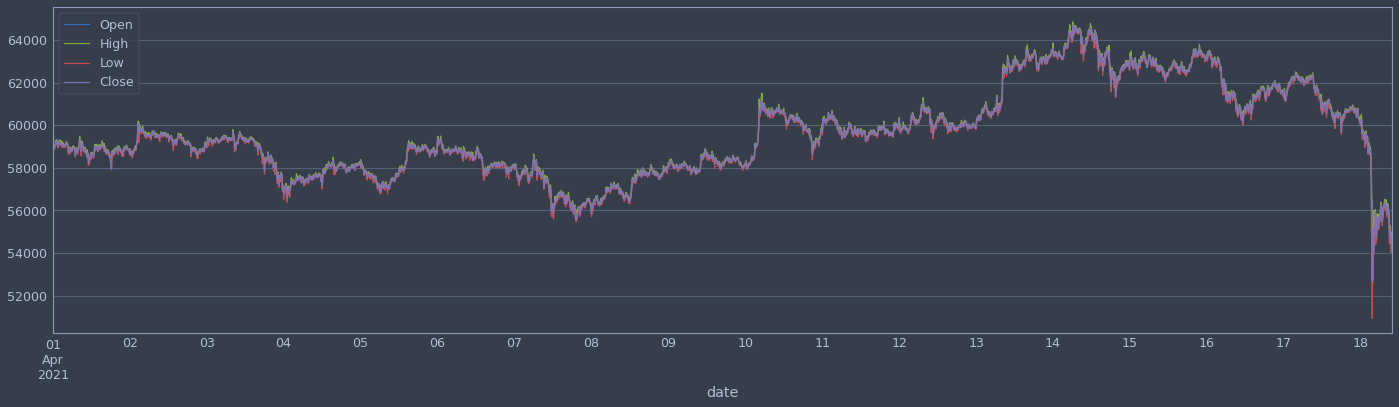

In [5]:
data[['Open','High','Low','Close']].plot(figsize=(24,6))

In [16]:
data[pd.isna(data.Open)]

,Open,High,Low,Close,Volume
date,,,,,
2021-02-11 04:00:00,NaN,NaN,NaN,NaN,NaN
2021-03-06 02:00:00,NaN,NaN,NaN,NaN,NaN


In [15]:
data

,Open,High,Low,Close,Volume
date,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...
2021-03-06 11:00:00,48035.37,48331.91,48000.00,48171.01,1402.215627
2021-03-06 12:00:00,48171.02,48212.85,47401.82,47660.74,3296.638061
2021-03-06 13:00:00,47660.75,47753.39,47070.00,47320.30,3107.861335


In [10]:
import statsmodels.api as sm
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.fft import fftshift

data = data.resample(rule='1h').asfreq()
decomposed_trends = sm.tsa.seasonal_decompose(data.Close)
observed_sig = decomposed_trends.observed
seasonal_sig = decomposed_trends.seasonal
trend_sig = decomposed_trends.trend
residual_sig = decomposed_trends.resid

fig, ax = plt.subplots(4, 1, figsize=(24,12), constrained_layout=True, sharex=True)
ax[0].plot(observed_sig, label='Close')
ax[0].set_title('Close')
ax[1].plot(trend_sig, label='Trend')
ax[1].set_title('Trend')
ax[2].plot(seasonal_sig, label='Seasonal')
ax[2].set_title('Seasonality')
ax[3].plot(residual_sig, label='Residual')
ax[3].set_title('Residual')
plt.legend()
plt.suptitle('BTC/USDT')
plt.show()

ValueError: This function does not handle missing values